In [1]:
import numpy as np
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os

# config device
device = torch.device('cpu')
import shap

In [2]:
device = torch.device('cpu')

# hyper-parameters
num_epochs = 7
num_classes = 10
batch_size = 100
learning_rate = 0.001

# FashionMNIST dataset
train_dataset = torchvision.datasets.FashionMNIST(
    root='../../data/',
    train=True,
    transform=transforms.ToTensor(),
    download=True
)
test_dataset = torchvision.datasets.FashionMNIST(
    root='../../data/',
    train=False,
    transform=transforms.ToTensor()
)

# Data load
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False
)

In [3]:
from models import ConvNetLin, ConvNetReLU

model_Lin = ConvNetLin(num_classes).to(device)
model_ReLU = ConvNetReLU(num_classes).to(device)

model_Lin.load_state_dict(torch.load('LinearCNN/linearCNN.ckpt'))
model_ReLU.load_state_dict(torch.load('ReLU/ReLU.ckpt'))

<All keys matched successfully>

Checking accuracy on test set
ReLU: 


Model Accuracy on the 10000 test images: 90.87 %
LinearCNN: 
Model Accuracy on the 10000 test images: 83.72 %



LinearCNN: 
Correctly classified images: 
Incorrectly classified images: 



ReLU: 
Correctly classified images: 
Incorrectly classified images: 





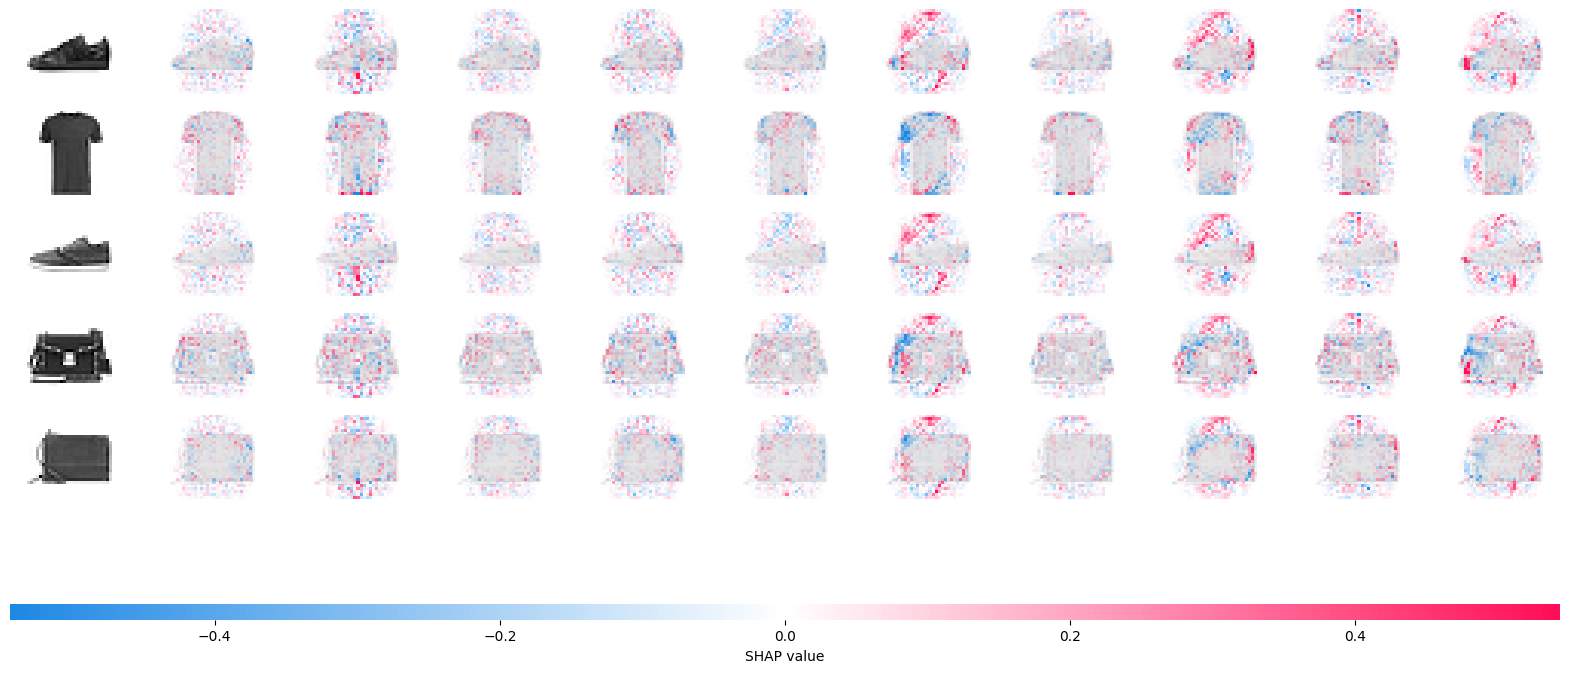

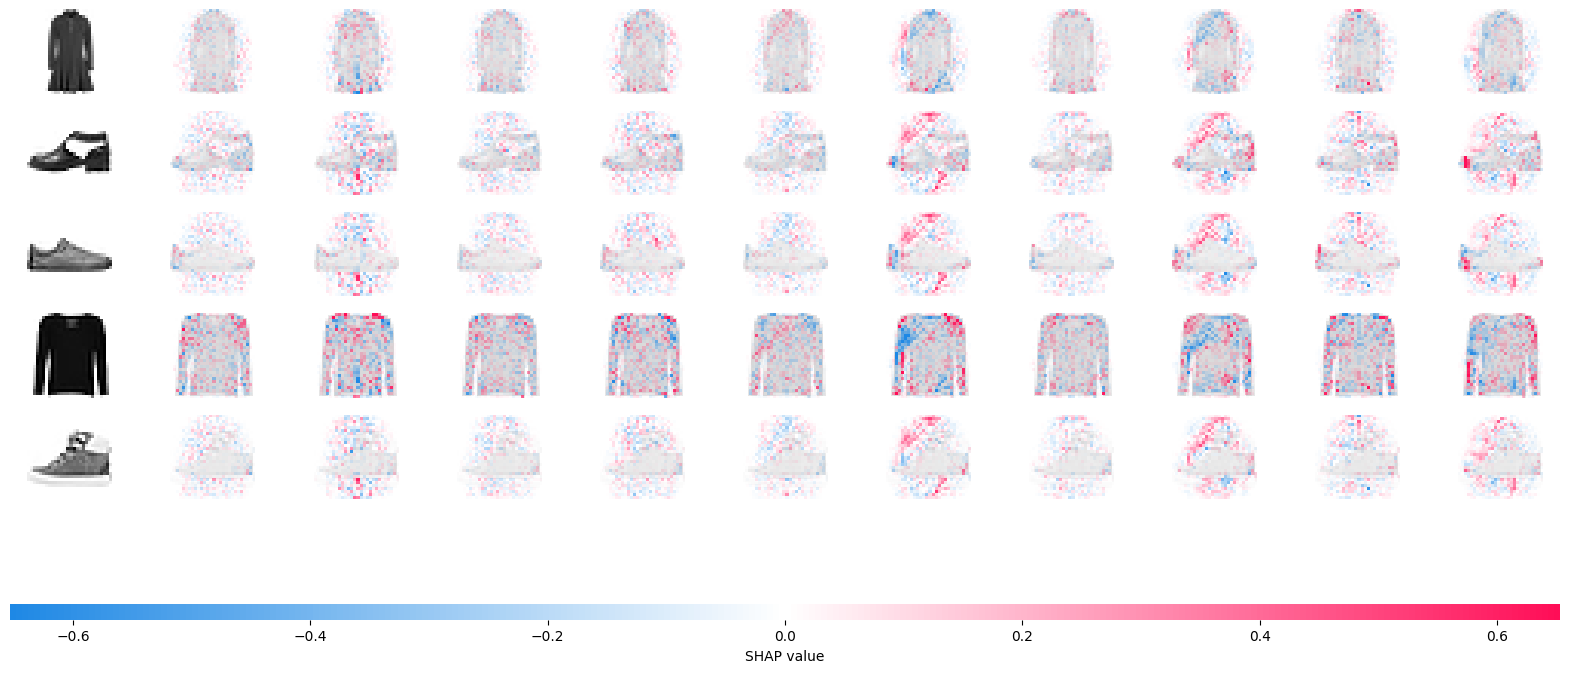

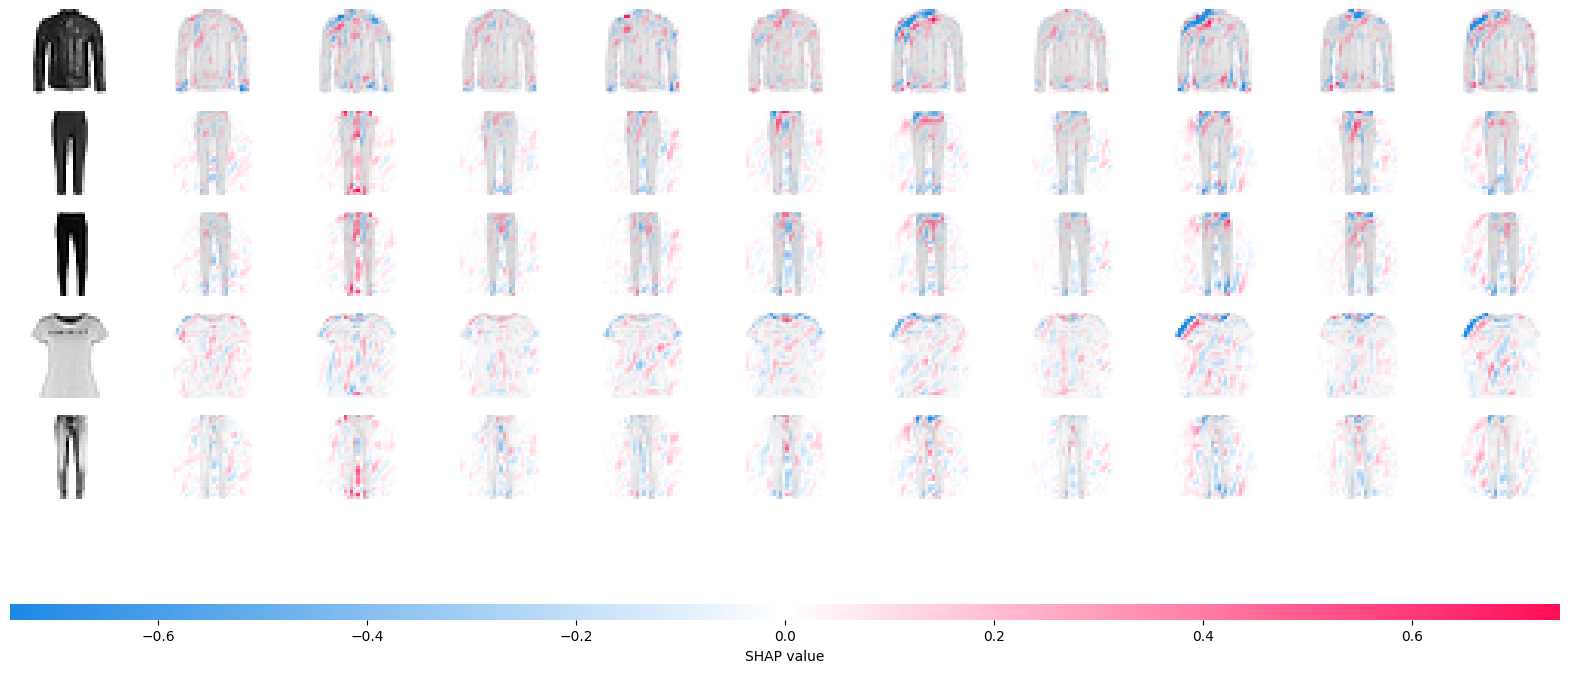

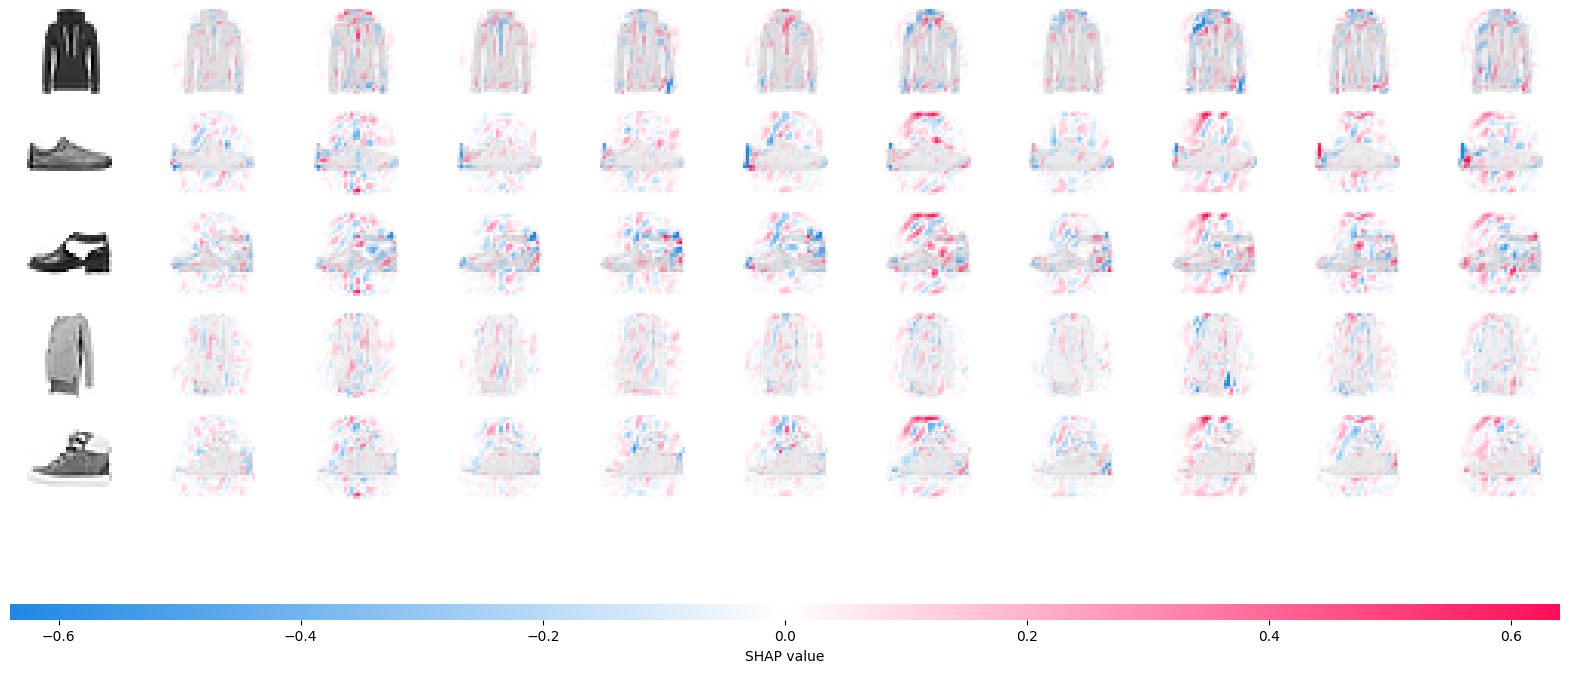

In [8]:
# Check accuracy on test to see how good our model
def check_accuracy(loader, model):
    model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Model Accuracy on the 10000 test images: {} %'.format(100 * correct / total))

    # with torch.no_grad():
    #     for x, y in loader:
    #         x = x.to(device=device)
    #         y = y.to(device=device)

    #         scores = model(x)
    #         _, predictions = scores.max(1)
    #         num_correct += (predictions == y).sum()
    #         num_samples += predictions.size(0)

    #     print(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}')
    # model.train()

print("Checking accuracy on test set")
print("ReLU: ")
check_accuracy(test_loader, model_ReLU)

print("LinearCNN: ")
check_accuracy(test_loader, model_Lin)
print("\n\n")




# Function to get indices of correctly classified images
def get_correctly_classified_indices(model, images, labels):
    with torch.no_grad():
        outputs = model(images)
        # Get the predicted classes for each image
        _, predicted = torch.max(outputs, 1)
        #print(predicted)
        correct_mask = predicted.eq(labels)
        correct_indices = torch.nonzero(correct_mask).squeeze()
    return correct_indices

#Fumction to get indeces of incorrectly classified images
def get_incorrectly_classified_indices(model, images, labels):
    with torch.no_grad():
        outputs = model(images)
        # Get the predicted classes for each image
        _, predicted = torch.max(outputs, 1)
        #print(predicted)
        incorrect_mask = predicted.ne(labels)
        incorrect_indices = torch.nonzero(incorrect_mask).squeeze()
    return incorrect_indices

# Load a batch of test images
batch = next(iter(test_loader))
images, labels = batch

# #Plot the selected images with their corresponding labels
names= ['T-shirt/top', 'Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']
# plt.figure(figsize=(10, 5))
# for i in range(5):
#     plt.subplot(1, 5, i + 1)
#     plt.imshow(selected_images[i][0], cmap='gray')
#     plt.title(names[selected_labels[i].item()])
#     plt.axis('off')

# Get a subset of FashionMNIST dataset for background
background = images[:500]
# Get a uniform background
#background= torch.zeros(100, 1, 28, 28)


# Function to plot images and their corresponding SHAP values
# def plot_shap_images(model, background, images, selected_labels):
#     # Initialize a SHAP DeepExplainer object
#     e = shap.DeepExplainer(model, background)
#     # Calculate SHAP values for the selected images
#     shap_values = e.shap_values(images)
#     # Swap axes for SHAP values
#     shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
    
#     plt.figure(figsize=(15, 3), dpi=100, facecolor='w', edgecolor='k')
#     num_images = len(images)
#     # Plot the SHAP interpretations
#     for i in range(num_images):
#         shap.image_plot(shap_numpy[i], -images[i].numpy(), show=False)
#         plt.title(names[selected_labels[i].item()])
#     plt.show()

def plot_shap_images(model, background, images, selected_labels):
    
    e = shap.DeepExplainer(model, background)
    shap_values = e.shap_values(images)
    shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
    test_numpy = np.swapaxes(np.swapaxes(images.numpy(), 1, -1), 1, 2)
    # plot the feature attributions
    shap.image_plot(shap_numpy, -test_numpy, show=False)
    #Save the plot
    file_name= 'shap' + model.__class__.__name__ + '_' + str(corr) + '.png'
    plt.savefig(file_name)
    

# Get indices of correctly classified images
correct_indices = get_correctly_classified_indices(model_Lin, images, labels)
incorrect_indeces = get_incorrectly_classified_indices(model_Lin, images, labels)

# Select 5 random indices
selected_indices = np.random.choice(correct_indices.numpy(), size=5, replace=False)
selected_indices_incorrect = np.random.choice(incorrect_indeces.numpy(), size=5, replace=False)


# Select the images and corresponding labels
selected_images = images[selected_indices]
outputs = model_Lin(selected_images)
# Get the predicted classes for each image
_, selected_labels = torch.max(outputs, 1)


selected_images_incorrect = images[selected_indices_incorrect]
outputs = model_Lin(selected_images_incorrect)
# Get the predicted classes for each image
_, selected_labels_incorrect = torch.max(outputs, 1)

# Plot SHAP interpretations for model_Lin
print("LinearCNN: ")
print("Correctly classified images: ")
corr=1
plot_shap_images(model_Lin, background, selected_images, selected_labels)
print("Incorrectly classified images: ")
corr=0
plot_shap_images(model_Lin, background, selected_images_incorrect, selected_labels_incorrect)
print("\n\n")



# Get indices of correctly classified images
correct_indices = get_correctly_classified_indices(model_ReLU, images, labels)
incorrect_indeces = get_incorrectly_classified_indices(model_ReLU, images, labels)

# Select 5 random indices
selected_indices = np.random.choice(correct_indices.numpy(), size=5, replace=False)
selected_indices_incorrect = np.random.choice(incorrect_indeces.numpy(), size=5, replace=False)

# Select the images and corresponding labels
selected_images = images[selected_indices]
outputs = model_ReLU(selected_images)
# Get the predicted classes for each image
_, selected_labels = torch.max(outputs, 1)

# Select the images and corresponding labels
selected_images_incorrect = images[selected_indices_incorrect]
outputs = model_ReLU(selected_images_incorrect)
# Get the predicted classes for each image
_, selected_labels_incorrect = torch.max(outputs, 1)

# Plot SHAP interpretations for model_ReLU
print("ReLU: ")
print("Correctly classified images: ")
corr=1
plot_shap_images(model_ReLU, background, selected_images, selected_labels)
print("Incorrectly classified images: ")
corr=0
plot_shap_images(model_ReLU, background, selected_images_incorrect, selected_labels_incorrect)
print("\n\n")
